In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from collections import Counter
from openpyxl import load_workbook
from difflib import get_close_matches
import unicodedata


In [2]:

def fill_model_metrics_into_excel(
    df: pd.DataFrame,
    model_name: str,
    selected_metrics = None,
    excel_path: str = None,
    output_path: str = None,
    sheet_name: str = None,
):
    # Normalize to avoid invisible characters and spaces
    def normalize(text: str) -> str:
        if text is None:
            return ""
        return unicodedata.normalize('NFKC', str(text)).strip().replace('\xa0', ' ')

    # Default to MSE and WAPE if not specified
    if selected_metrics is None:
        selected_metrics = ["MSE", "WAPE"]
    else:
        selected_metrics = [m.upper() for m in selected_metrics]

    # Extract pred_len
    pred_len_values = df["pred_len"].unique()
    if len(pred_len_values) != 1:
        raise ValueError(f"Expected a single pred_len, got: {pred_len_values}")
    pred_len = int(pred_len_values[0])

    # Load workbook and worksheet
    wb = load_workbook(excel_path)
    if sheet_name:
        if sheet_name not in wb.sheetnames:
            raise ValueError(f"Sheet '{sheet_name}' not found in workbook. Available: {wb.sheetnames}")
        ws = wb[sheet_name]
    else:
        ws = wb.active

    # Map model and metric columns
    col_map = {}
    target = normalize(model_name)

    print(f"🔎 Looking for model: {repr(target)}")
    for col in range(3, ws.max_column + 1):
        model_cell = ws.cell(row=1, column=col).value
        model_clean = normalize(model_cell)
        if model_clean != target:
            continue

        metric_name = ws.cell(row=2, column=col).value
        if not metric_name:
            continue

        metric_name = normalize(metric_name).upper()
        print(f"  Col {col}: model={repr(model_clean)} | metric={metric_name}")

        if metric_name in selected_metrics:
            col_map[metric_name] = col

    if not col_map:
        raise ValueError(
            f"No matching columns found for model '{model_name}' and metrics {selected_metrics}"
        )

    # Function to find or append target row
    def find_or_insert_row(group: str, pred_len: int):
        for row in range(3, ws.max_row + 1):
            g = ws.cell(row=row, column=1).value
            p = ws.cell(row=row, column=2).value
            try:
                if g == group and int(p) == int(pred_len):
                    return row
            except:
                continue
        # Not found: insert
        new_row = ws.max_row + 1
        ws.cell(row=new_row, column=1, value=group)
        ws.cell(row=new_row, column=2, value=pred_len)
        return new_row

    # Fill values
    for _, row_data in df.iterrows():
        group = row_data["group"]
        row_idx = find_or_insert_row(group, pred_len)
        for metric in selected_metrics:
            col_idx = col_map.get(metric)
            if col_idx is None:
                continue
            val = (
                row_data.get(metric.lower()) or
                row_data.get(metric.upper()) or
                row_data.get(metric)
            )
            if pd.notna(val):
                ws.cell(row=row_idx, column=col_idx, value=float(val))

    save_path = output_path or excel_path
    wb.save(save_path)
    print(f"✅ Filled '{model_name}' (pred_len={pred_len}) into: {save_path}, sheet: {ws.title}")


In [3]:

def show_results(root_dir):
    summary_results = []
    total_json_count = 0
    all_model_paths = []

    # === Traverse and summarize ===
    for group_dir in sorted(root_dir.iterdir()):
        if not group_dir.is_dir():
            continue

        metrics_list = []

        for subdir in group_dir.iterdir():
            if not subdir.is_dir():
                continue

            json_file = subdir / "results.json"
            if json_file.exists():
                total_json_count += 1
                with open(json_file, "r") as f:
                    data = json.load(f)
                    data["group"] = group_dir.name
                    metrics_list.append(data)
                    all_model_paths.append(data.get("model_path", "unknown"))

        if metrics_list:
            df = pd.DataFrame(metrics_list)
            df_mean = df.drop(columns=["dataset", "freq", "model_path"]).mean(numeric_only=True)
            df_mean["group"] = group_dir.name
            summary_results.append(df_mean)

    # === Combine summaries ===
    summary_df = pd.DataFrame(summary_results)
    summary_df.sort_values("group", inplace=True)

    # === Display summary table ===
    print("\n📊 Summary of Mean Metrics per Dataset Group:")
    display(summary_df)

    # === Compute overall global mean across all groups ===
    global_means = summary_df.drop(columns=["group"]).mean(numeric_only=True)
    print("\n📌 Global Mean Across All Groups:")
    print(global_means.round(4))

    # === Determine model name to display in title ===
    model_name = Counter(all_model_paths).most_common(1)[0][0] if all_model_paths else "Unknown Model"

    # === Visualization ===
    plt.figure(figsize=(12, 6))
    for metric in ["mse", "mae", "smape", "wape", "nrmse"]:
        if metric in summary_df.columns:
            plt.plot(summary_df["group"], summary_df[metric], marker='o', label=metric)

    plt.xticks(rotation=45)
    plt.xlabel("Dataset Group")
    plt.ylabel("Metric Value")
    plt.title(f"Average Forecasting Metrics by Dataset Group\nModel: {model_name} pred len: {summary_df['pred_len'][0]} context len: {summary_df['context_len'][0]}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Total json count ===
    print(f"\n🔢 Total number of results.json files found: {total_json_count}")

    return summary_df

In [4]:
excel_file_path = r"C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx"
wb = load_workbook(excel_file_path)
ws = wb.active
# Parse all model name columns
model_col_map = {}
for col in range(3, ws.max_column + 1, 1):
    model = ws.cell(row=1, column=col).value
    if model is None:
        continue
    model = model.strip()
    model_col_map[model] = {
    }

print("Available models in Excel headers:", list(model_col_map.keys()))

def print_excel_sheet_contents(excel_path, sheet_name=None):
    wb = load_workbook(excel_path, data_only=True)
    ws = wb[sheet_name] if sheet_name else wb.active

    print("=== Excel Sheet Content ===")
    for row in ws.iter_rows(values_only=True):
        print(row)

#print_excel_sheet_contents(excel_file_path)


Available models in Excel headers: ['TimesFM 200M', 'TimesFM 500M', 'Chronos small', 'Chronos Medium', 'Chronos Large', 'TimesMOE Large', 'FTFM v4 lowq (mean)', 'FTFM v4 (medium5)', 'FTFM v4 (mean)', 'FTFM v3t  (median5)', 'FTFM v3t DDP  (median5)']


## Work Section


📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.192884,0.358176,0.208358,0.276314,0.567380,3653.333333,2840.513428,9.172409,20.0,128.0,crypto10_1d
1,0.023762,0.246365,0.095364,0.109595,0.177186,20880.000000,18160.557617,51.610696,20.0,128.0,crypto10_1h
2,0.046503,0.267205,0.119117,0.142735,0.258498,8853.333333,7392.073242,21.574010,20.0,128.0,crypto10_1m
3,0.090180,0.324805,0.183015,0.204842,0.327974,6920.000000,6179.074707,17.325769,20.0,128.0,forex_datasets_1d
4,0.035427,0.262559,0.115743,0.137029,0.217259,20693.333333,17704.054688,51.486228,20.0,128.0,forex_datasets_1h
5,0.094603,0.344021,0.174947,0.202140,0.337503,12160.000000,10519.006510,30.290631,20.0,128.0,forex_datasets_1m
6,0.509767,0.869793,0.476862,0.614063,0.922939,2000.000000,1563.865031,5.163369,20.0,128.0,forex_datasets_1wk
7,0.145981,0.479083,0.192486,0.255910,0.504311,7240.000000,5461.366089,18.181066,20.0,128.0,futures_datasets_1d
8,0.042576,0.241644,0.116028,0.131288,0.233477,16160.000000,14281.685547,40.533346,20.0,128.0,futures_datasets_1h
9,0.205751,0.468361,0.246864,0.297924,0.435336,9120.000000,7832.895752,22.902465,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1884
smape              0.4449
mae                0.2316
wape               0.2839
nrmse              0.4750
num_elements    8500.5135
abs_sum         7219.2052
total_time        21.1994
pred_len          20.0000
context_len      128.0000
dtype: float64


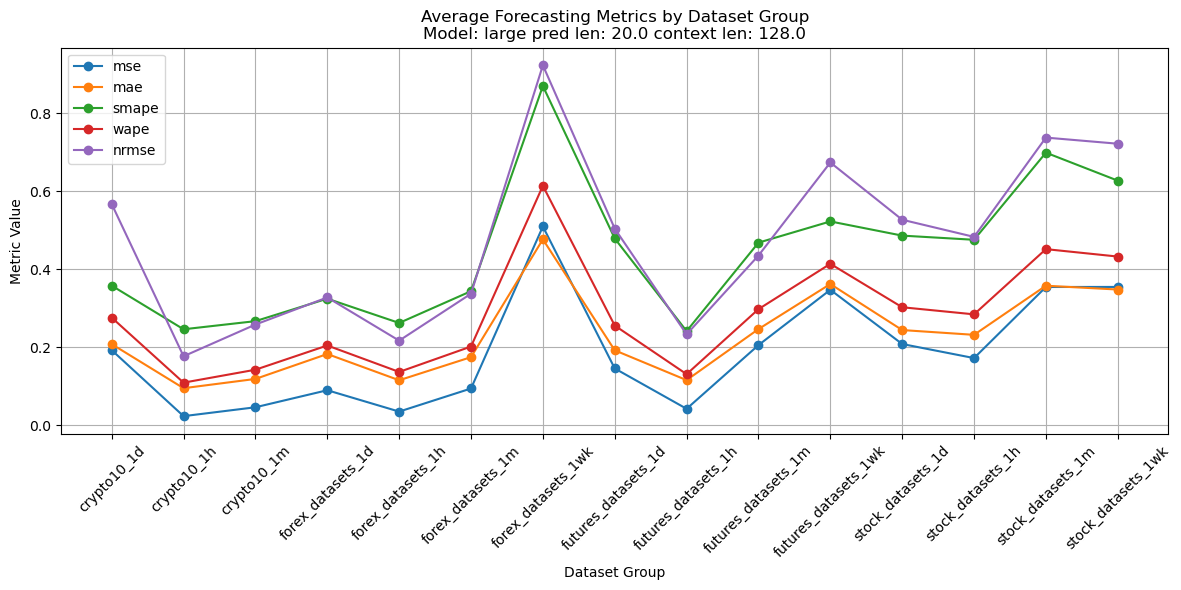


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MSE
✅ Filled 'TimesMOE Large' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290782,0.439859,0.268996,0.354951,0.693133,3680.000000,2867.131429,8.540728,30.0,128.0,crypto10_1d
1,0.034568,0.284720,0.114565,0.131668,0.213726,20880.000000,18160.559570,47.701517,30.0,128.0,crypto10_1h
2,0.068342,0.328316,0.146232,0.175831,0.314961,8800.000000,7310.747884,19.892892,30.0,128.0,crypto10_1m
3,0.131349,0.366561,0.224181,0.250870,0.397096,6900.000000,6164.434570,16.012319,30.0,128.0,forex_datasets_1d
4,0.051097,0.315649,0.141978,0.168896,0.262064,20640.000000,17603.581380,48.008559,30.0,128.0,forex_datasets_1h
5,0.145177,0.409186,0.220233,0.254665,0.424396,12120.000000,10474.398112,27.890211,30.0,128.0,forex_datasets_1m
6,0.637604,0.970492,0.543173,0.699432,1.031408,2040.000000,1600.562541,4.879077,30.0,128.0,forex_datasets_1wk
7,0.201020,0.544477,0.233643,0.311575,0.594247,7200.000000,5408.967285,16.650229,30.0,128.0,futures_datasets_1d
8,0.061010,0.292945,0.145608,0.164530,0.279101,16080.000000,14230.698242,37.747937,30.0,128.0,futures_datasets_1h
9,0.239605,0.532483,0.284984,0.342844,0.492552,9080.000000,7780.715047,21.335367,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2612
smape              0.5144
mae                0.2810
wape               0.3438
nrmse              0.5638
num_elements    8482.6778
abs_sum         7197.0067
total_time        19.6422
pred_len          30.0000
context_len      128.0000
dtype: float64


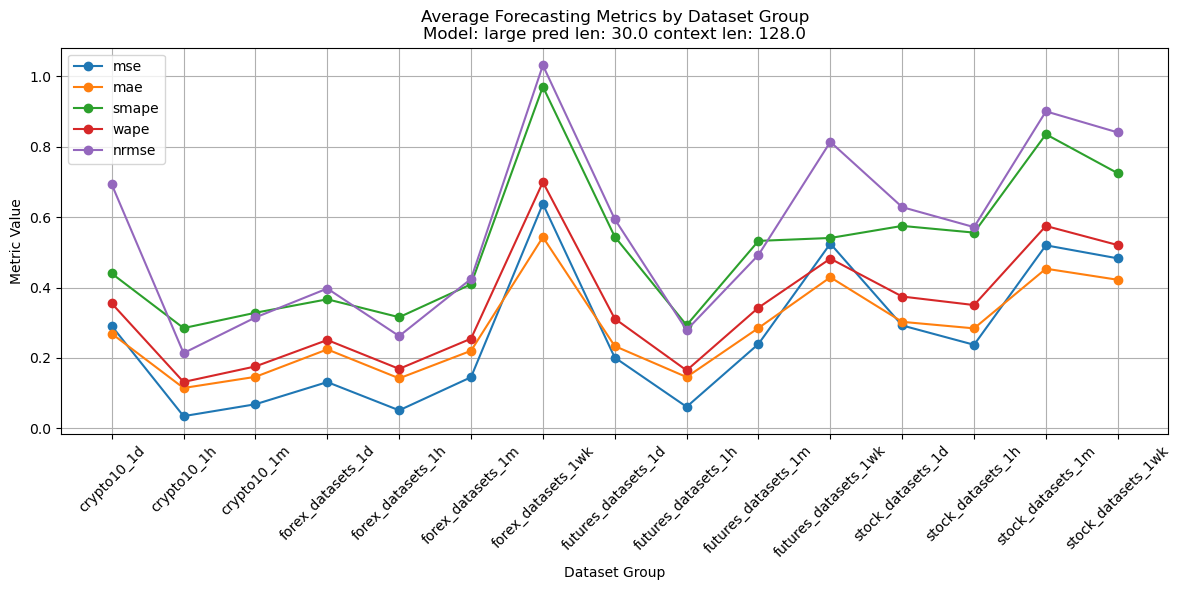


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MSE
✅ Filled 'TimesMOE Large' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.533066,0.622696,0.406333,0.548822,0.955574,3600.000000,2775.409180,3.891764,60.0,128.0,crypto10_1d
1,0.074708,0.384306,0.172504,0.198217,0.313512,20880.000000,18160.557617,22.188303,60.0,128.0,crypto10_1h
2,0.138654,0.422921,0.218041,0.262321,0.448431,8800.000000,7310.747721,9.274022,60.0,128.0,crypto10_1m
3,0.220529,0.482237,0.302363,0.337512,0.514324,6840.000000,6124.638184,7.384680,60.0,128.0,forex_datasets_1d
4,0.107025,0.422879,0.208626,0.247825,0.377415,20560.000000,17539.440104,22.879885,60.0,128.0,forex_datasets_1h
5,0.291079,0.565783,0.332999,0.385725,0.609282,12000.000000,10344.388346,12.889020,60.0,128.0,forex_datasets_1m
6,0.883304,1.199889,0.680231,0.876888,1.215506,1920.000000,1488.001546,2.132136,60.0,128.0,forex_datasets_1wk
7,0.381527,0.671700,0.330679,0.446451,0.834492,7080.000000,5251.835938,7.636587,60.0,128.0,futures_datasets_1d
8,0.112845,0.378006,0.206352,0.233168,0.379577,16080.000000,14230.702148,17.271233,60.0,128.0,futures_datasets_1h
9,0.322892,0.632296,0.357022,0.426120,0.619612,9000.000000,7713.614176,9.791542,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.4315
smape              0.6622
mae                0.3885
wape               0.4794
nrmse              0.7462
num_elements    8412.9351
abs_sum         7119.8149
total_time         9.1105
pred_len          60.0000
context_len      128.0000
dtype: float64


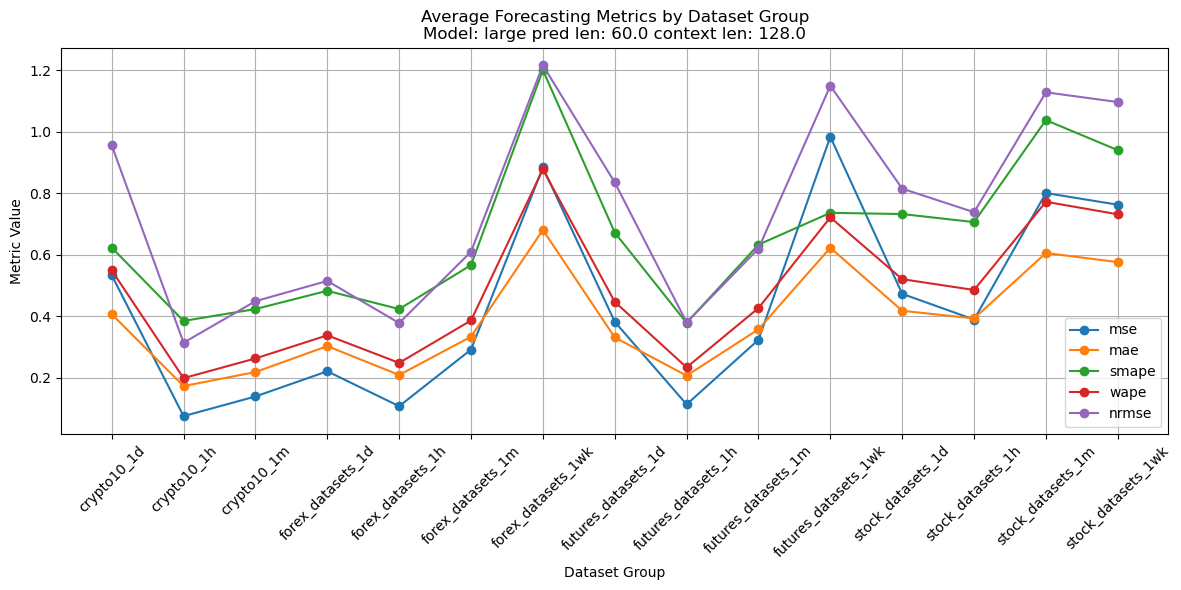


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MSE
✅ Filled 'TimesMOE Large' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.192884,0.358176,0.208358,0.276314,0.567380,3653.333333,2840.513428,9.172409,20.0,128.0,crypto10_1d
1,0.023762,0.246365,0.095364,0.109595,0.177186,20880.000000,18160.557617,51.610696,20.0,128.0,crypto10_1h
2,0.046503,0.267205,0.119117,0.142735,0.258498,8853.333333,7392.073242,21.574010,20.0,128.0,crypto10_1m
3,0.090180,0.324805,0.183015,0.204842,0.327974,6920.000000,6179.074707,17.325769,20.0,128.0,forex_datasets_1d
4,0.035427,0.262559,0.115743,0.137029,0.217259,20693.333333,17704.054688,51.486228,20.0,128.0,forex_datasets_1h
5,0.094603,0.344021,0.174947,0.202140,0.337503,12160.000000,10519.006510,30.290631,20.0,128.0,forex_datasets_1m
6,0.509767,0.869793,0.476862,0.614063,0.922939,2000.000000,1563.865031,5.163369,20.0,128.0,forex_datasets_1wk
7,0.145981,0.479083,0.192486,0.255910,0.504311,7240.000000,5461.366089,18.181066,20.0,128.0,futures_datasets_1d
8,0.042576,0.241644,0.116028,0.131288,0.233477,16160.000000,14281.685547,40.533346,20.0,128.0,futures_datasets_1h
9,0.205751,0.468361,0.246864,0.297924,0.435336,9120.000000,7832.895752,22.902465,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1884
smape              0.4449
mae                0.2316
wape               0.2839
nrmse              0.4750
num_elements    8500.5135
abs_sum         7219.2052
total_time        21.1994
pred_len          20.0000
context_len      128.0000
dtype: float64


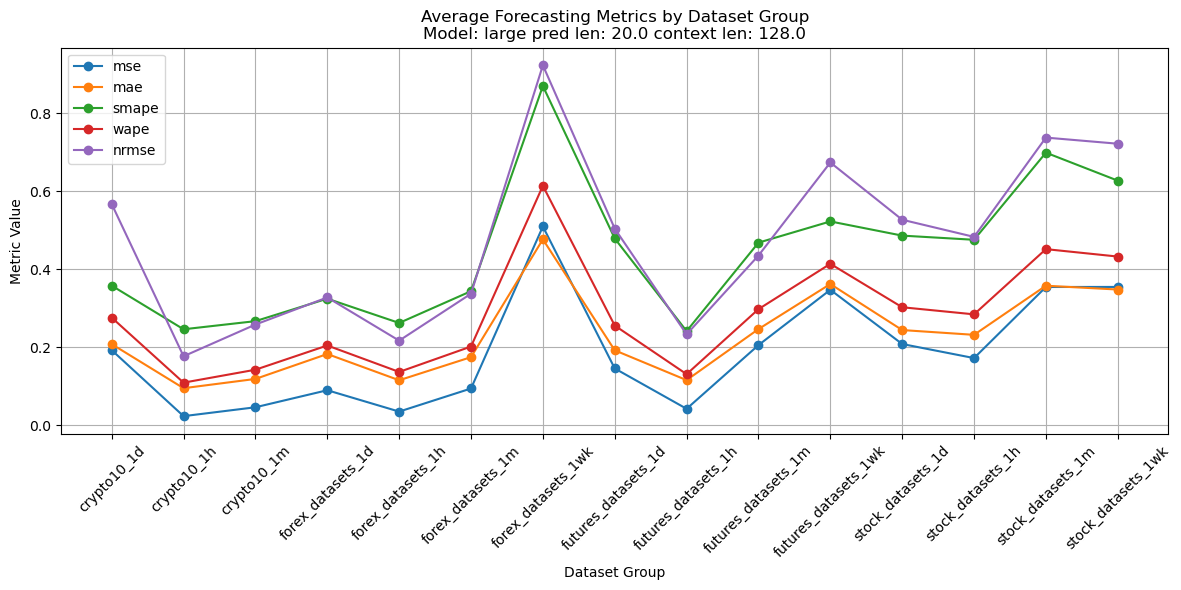


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MAE
✅ Filled 'TimesMOE Large' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290782,0.439859,0.268996,0.354951,0.693133,3680.000000,2867.131429,8.540728,30.0,128.0,crypto10_1d
1,0.034568,0.284720,0.114565,0.131668,0.213726,20880.000000,18160.559570,47.701517,30.0,128.0,crypto10_1h
2,0.068342,0.328316,0.146232,0.175831,0.314961,8800.000000,7310.747884,19.892892,30.0,128.0,crypto10_1m
3,0.131349,0.366561,0.224181,0.250870,0.397096,6900.000000,6164.434570,16.012319,30.0,128.0,forex_datasets_1d
4,0.051097,0.315649,0.141978,0.168896,0.262064,20640.000000,17603.581380,48.008559,30.0,128.0,forex_datasets_1h
5,0.145177,0.409186,0.220233,0.254665,0.424396,12120.000000,10474.398112,27.890211,30.0,128.0,forex_datasets_1m
6,0.637604,0.970492,0.543173,0.699432,1.031408,2040.000000,1600.562541,4.879077,30.0,128.0,forex_datasets_1wk
7,0.201020,0.544477,0.233643,0.311575,0.594247,7200.000000,5408.967285,16.650229,30.0,128.0,futures_datasets_1d
8,0.061010,0.292945,0.145608,0.164530,0.279101,16080.000000,14230.698242,37.747937,30.0,128.0,futures_datasets_1h
9,0.239605,0.532483,0.284984,0.342844,0.492552,9080.000000,7780.715047,21.335367,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2612
smape              0.5144
mae                0.2810
wape               0.3438
nrmse              0.5638
num_elements    8482.6778
abs_sum         7197.0067
total_time        19.6422
pred_len          30.0000
context_len      128.0000
dtype: float64


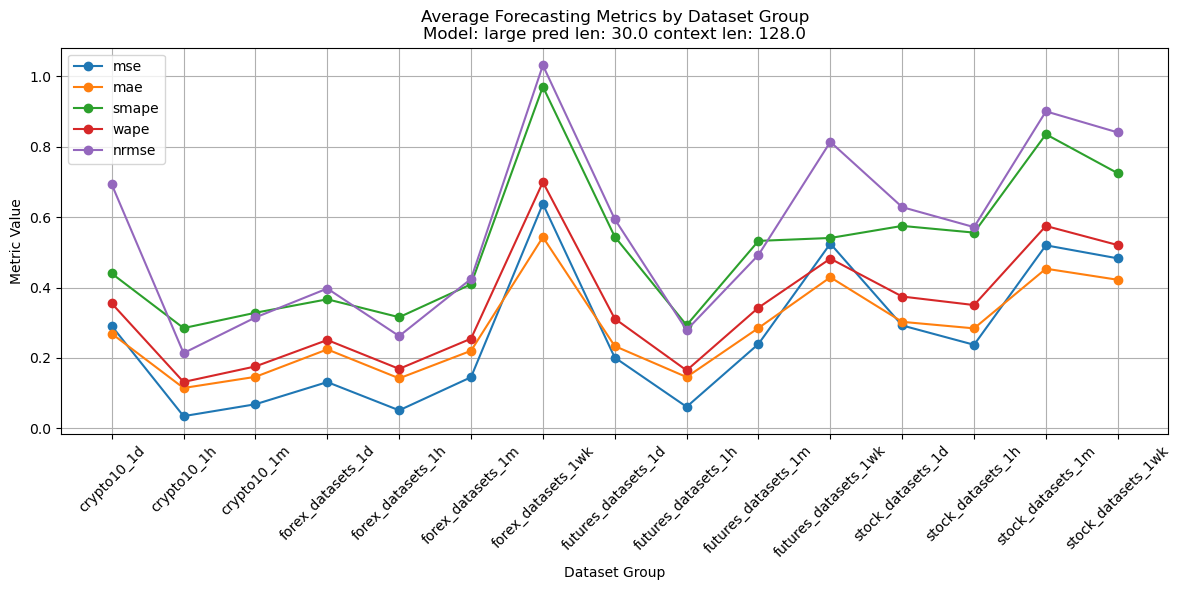


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MAE
✅ Filled 'TimesMOE Large' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.533066,0.622696,0.406333,0.548822,0.955574,3600.000000,2775.409180,3.891764,60.0,128.0,crypto10_1d
1,0.074708,0.384306,0.172504,0.198217,0.313512,20880.000000,18160.557617,22.188303,60.0,128.0,crypto10_1h
2,0.138654,0.422921,0.218041,0.262321,0.448431,8800.000000,7310.747721,9.274022,60.0,128.0,crypto10_1m
3,0.220529,0.482237,0.302363,0.337512,0.514324,6840.000000,6124.638184,7.384680,60.0,128.0,forex_datasets_1d
4,0.107025,0.422879,0.208626,0.247825,0.377415,20560.000000,17539.440104,22.879885,60.0,128.0,forex_datasets_1h
5,0.291079,0.565783,0.332999,0.385725,0.609282,12000.000000,10344.388346,12.889020,60.0,128.0,forex_datasets_1m
6,0.883304,1.199889,0.680231,0.876888,1.215506,1920.000000,1488.001546,2.132136,60.0,128.0,forex_datasets_1wk
7,0.381527,0.671700,0.330679,0.446451,0.834492,7080.000000,5251.835938,7.636587,60.0,128.0,futures_datasets_1d
8,0.112845,0.378006,0.206352,0.233168,0.379577,16080.000000,14230.702148,17.271233,60.0,128.0,futures_datasets_1h
9,0.322892,0.632296,0.357022,0.426120,0.619612,9000.000000,7713.614176,9.791542,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.4315
smape              0.6622
mae                0.3885
wape               0.4794
nrmse              0.7462
num_elements    8412.9351
abs_sum         7119.8149
total_time         9.1105
pred_len          60.0000
context_len      128.0000
dtype: float64


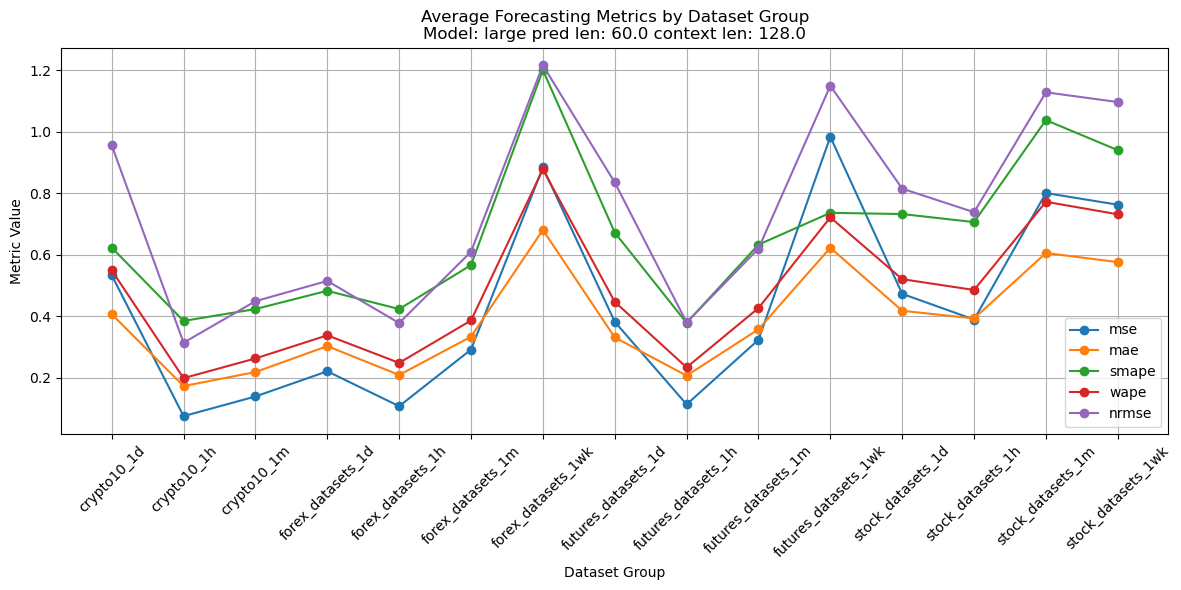


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=MAE
✅ Filled 'TimesMOE Large' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: mae

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.192884,0.358176,0.208358,0.276314,0.567380,3653.333333,2840.513428,9.172409,20.0,128.0,crypto10_1d
1,0.023762,0.246365,0.095364,0.109595,0.177186,20880.000000,18160.557617,51.610696,20.0,128.0,crypto10_1h
2,0.046503,0.267205,0.119117,0.142735,0.258498,8853.333333,7392.073242,21.574010,20.0,128.0,crypto10_1m
3,0.090180,0.324805,0.183015,0.204842,0.327974,6920.000000,6179.074707,17.325769,20.0,128.0,forex_datasets_1d
4,0.035427,0.262559,0.115743,0.137029,0.217259,20693.333333,17704.054688,51.486228,20.0,128.0,forex_datasets_1h
5,0.094603,0.344021,0.174947,0.202140,0.337503,12160.000000,10519.006510,30.290631,20.0,128.0,forex_datasets_1m
6,0.509767,0.869793,0.476862,0.614063,0.922939,2000.000000,1563.865031,5.163369,20.0,128.0,forex_datasets_1wk
7,0.145981,0.479083,0.192486,0.255910,0.504311,7240.000000,5461.366089,18.181066,20.0,128.0,futures_datasets_1d
8,0.042576,0.241644,0.116028,0.131288,0.233477,16160.000000,14281.685547,40.533346,20.0,128.0,futures_datasets_1h
9,0.205751,0.468361,0.246864,0.297924,0.435336,9120.000000,7832.895752,22.902465,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1884
smape              0.4449
mae                0.2316
wape               0.2839
nrmse              0.4750
num_elements    8500.5135
abs_sum         7219.2052
total_time        21.1994
pred_len          20.0000
context_len      128.0000
dtype: float64


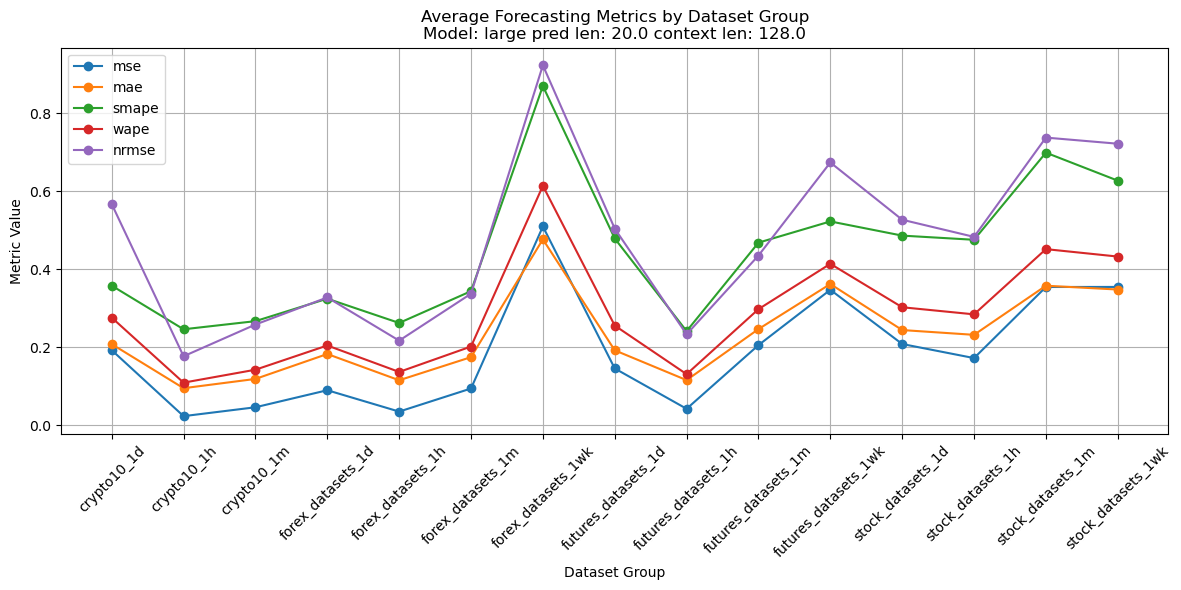


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=SMAPE
✅ Filled 'TimesMOE Large' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290782,0.439859,0.268996,0.354951,0.693133,3680.000000,2867.131429,8.540728,30.0,128.0,crypto10_1d
1,0.034568,0.284720,0.114565,0.131668,0.213726,20880.000000,18160.559570,47.701517,30.0,128.0,crypto10_1h
2,0.068342,0.328316,0.146232,0.175831,0.314961,8800.000000,7310.747884,19.892892,30.0,128.0,crypto10_1m
3,0.131349,0.366561,0.224181,0.250870,0.397096,6900.000000,6164.434570,16.012319,30.0,128.0,forex_datasets_1d
4,0.051097,0.315649,0.141978,0.168896,0.262064,20640.000000,17603.581380,48.008559,30.0,128.0,forex_datasets_1h
5,0.145177,0.409186,0.220233,0.254665,0.424396,12120.000000,10474.398112,27.890211,30.0,128.0,forex_datasets_1m
6,0.637604,0.970492,0.543173,0.699432,1.031408,2040.000000,1600.562541,4.879077,30.0,128.0,forex_datasets_1wk
7,0.201020,0.544477,0.233643,0.311575,0.594247,7200.000000,5408.967285,16.650229,30.0,128.0,futures_datasets_1d
8,0.061010,0.292945,0.145608,0.164530,0.279101,16080.000000,14230.698242,37.747937,30.0,128.0,futures_datasets_1h
9,0.239605,0.532483,0.284984,0.342844,0.492552,9080.000000,7780.715047,21.335367,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2612
smape              0.5144
mae                0.2810
wape               0.3438
nrmse              0.5638
num_elements    8482.6778
abs_sum         7197.0067
total_time        19.6422
pred_len          30.0000
context_len      128.0000
dtype: float64


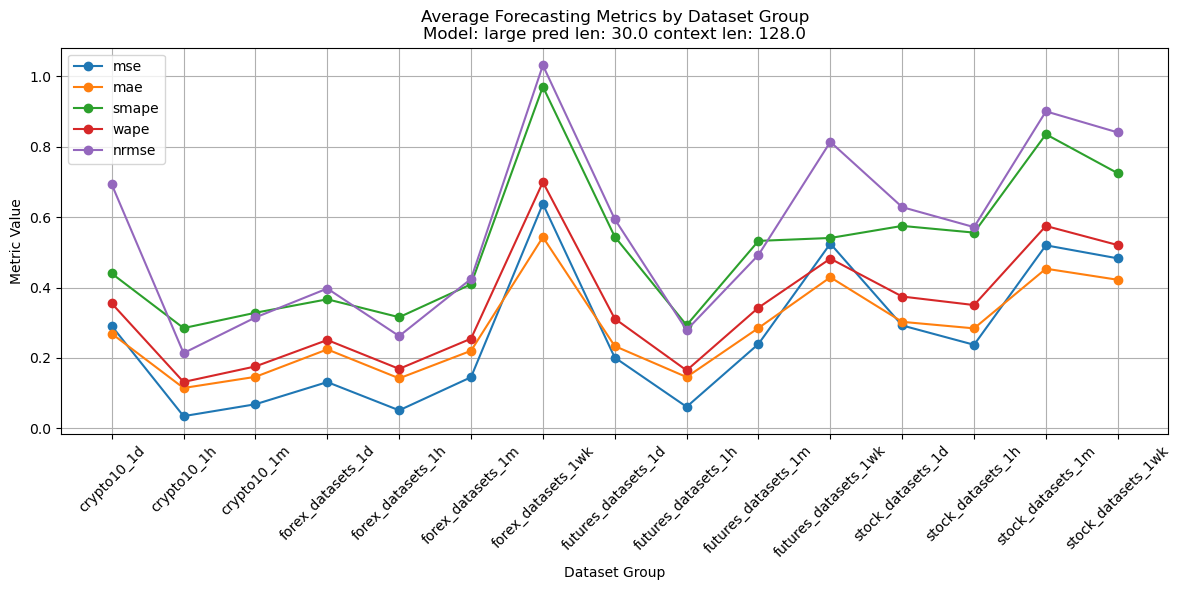


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=SMAPE
✅ Filled 'TimesMOE Large' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.533066,0.622696,0.406333,0.548822,0.955574,3600.000000,2775.409180,3.891764,60.0,128.0,crypto10_1d
1,0.074708,0.384306,0.172504,0.198217,0.313512,20880.000000,18160.557617,22.188303,60.0,128.0,crypto10_1h
2,0.138654,0.422921,0.218041,0.262321,0.448431,8800.000000,7310.747721,9.274022,60.0,128.0,crypto10_1m
3,0.220529,0.482237,0.302363,0.337512,0.514324,6840.000000,6124.638184,7.384680,60.0,128.0,forex_datasets_1d
4,0.107025,0.422879,0.208626,0.247825,0.377415,20560.000000,17539.440104,22.879885,60.0,128.0,forex_datasets_1h
5,0.291079,0.565783,0.332999,0.385725,0.609282,12000.000000,10344.388346,12.889020,60.0,128.0,forex_datasets_1m
6,0.883304,1.199889,0.680231,0.876888,1.215506,1920.000000,1488.001546,2.132136,60.0,128.0,forex_datasets_1wk
7,0.381527,0.671700,0.330679,0.446451,0.834492,7080.000000,5251.835938,7.636587,60.0,128.0,futures_datasets_1d
8,0.112845,0.378006,0.206352,0.233168,0.379577,16080.000000,14230.702148,17.271233,60.0,128.0,futures_datasets_1h
9,0.322892,0.632296,0.357022,0.426120,0.619612,9000.000000,7713.614176,9.791542,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.4315
smape              0.6622
mae                0.3885
wape               0.4794
nrmse              0.7462
num_elements    8412.9351
abs_sum         7119.8149
total_time         9.1105
pred_len          60.0000
context_len      128.0000
dtype: float64


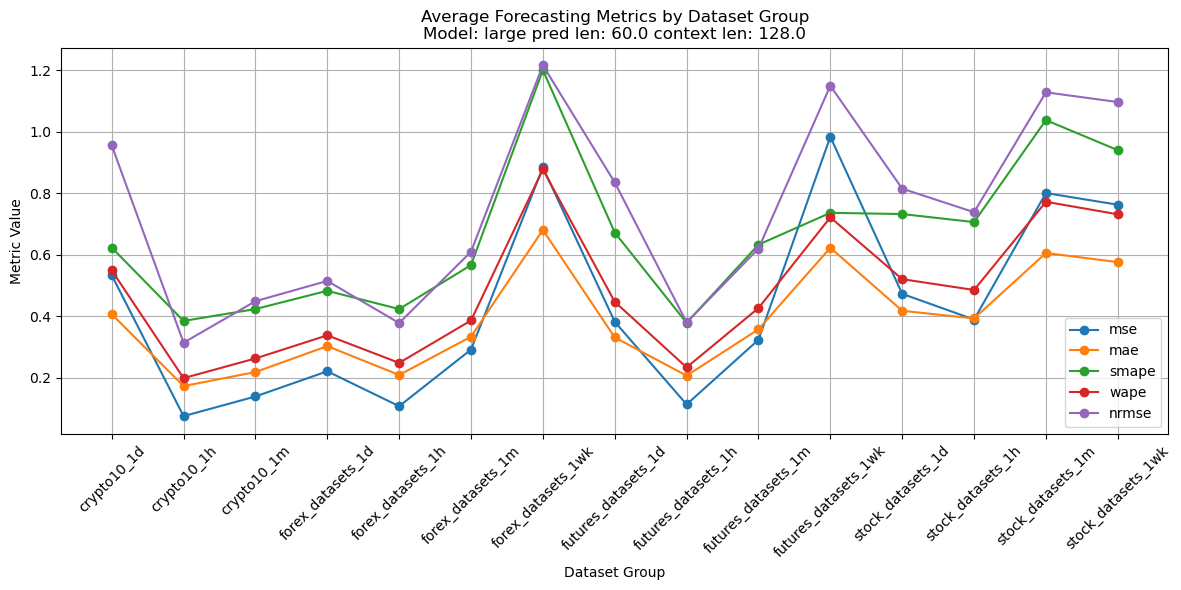


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=SMAPE
✅ Filled 'TimesMOE Large' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: smape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.192884,0.358176,0.208358,0.276314,0.567380,3653.333333,2840.513428,9.172409,20.0,128.0,crypto10_1d
1,0.023762,0.246365,0.095364,0.109595,0.177186,20880.000000,18160.557617,51.610696,20.0,128.0,crypto10_1h
2,0.046503,0.267205,0.119117,0.142735,0.258498,8853.333333,7392.073242,21.574010,20.0,128.0,crypto10_1m
3,0.090180,0.324805,0.183015,0.204842,0.327974,6920.000000,6179.074707,17.325769,20.0,128.0,forex_datasets_1d
4,0.035427,0.262559,0.115743,0.137029,0.217259,20693.333333,17704.054688,51.486228,20.0,128.0,forex_datasets_1h
5,0.094603,0.344021,0.174947,0.202140,0.337503,12160.000000,10519.006510,30.290631,20.0,128.0,forex_datasets_1m
6,0.509767,0.869793,0.476862,0.614063,0.922939,2000.000000,1563.865031,5.163369,20.0,128.0,forex_datasets_1wk
7,0.145981,0.479083,0.192486,0.255910,0.504311,7240.000000,5461.366089,18.181066,20.0,128.0,futures_datasets_1d
8,0.042576,0.241644,0.116028,0.131288,0.233477,16160.000000,14281.685547,40.533346,20.0,128.0,futures_datasets_1h
9,0.205751,0.468361,0.246864,0.297924,0.435336,9120.000000,7832.895752,22.902465,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1884
smape              0.4449
mae                0.2316
wape               0.2839
nrmse              0.4750
num_elements    8500.5135
abs_sum         7219.2052
total_time        21.1994
pred_len          20.0000
context_len      128.0000
dtype: float64


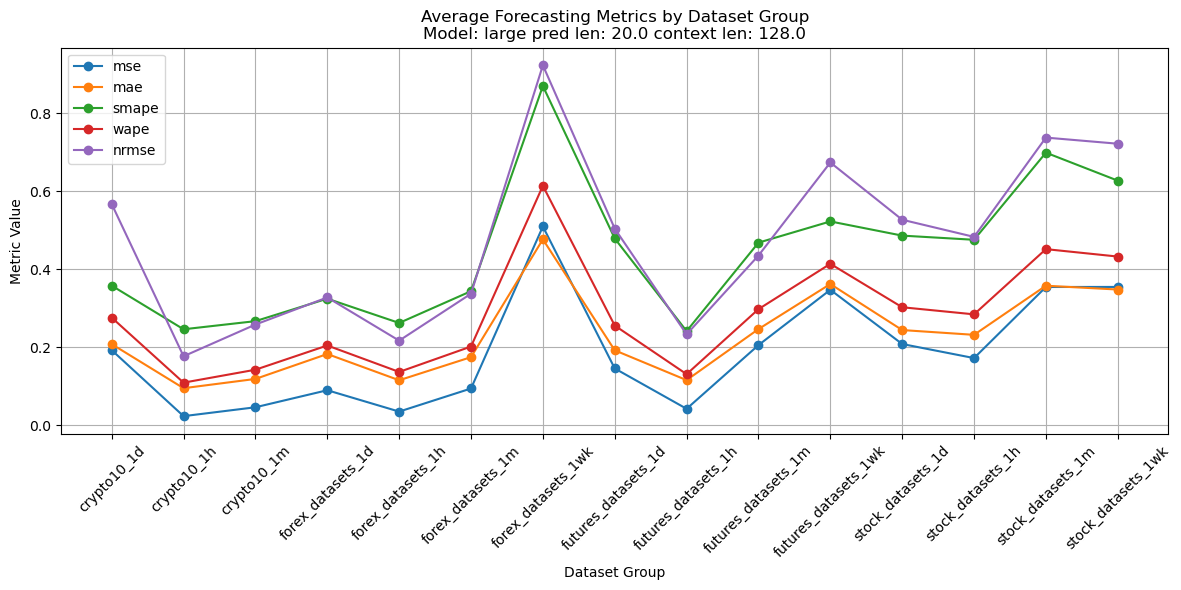


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=WAPE
✅ Filled 'TimesMOE Large' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290782,0.439859,0.268996,0.354951,0.693133,3680.000000,2867.131429,8.540728,30.0,128.0,crypto10_1d
1,0.034568,0.284720,0.114565,0.131668,0.213726,20880.000000,18160.559570,47.701517,30.0,128.0,crypto10_1h
2,0.068342,0.328316,0.146232,0.175831,0.314961,8800.000000,7310.747884,19.892892,30.0,128.0,crypto10_1m
3,0.131349,0.366561,0.224181,0.250870,0.397096,6900.000000,6164.434570,16.012319,30.0,128.0,forex_datasets_1d
4,0.051097,0.315649,0.141978,0.168896,0.262064,20640.000000,17603.581380,48.008559,30.0,128.0,forex_datasets_1h
5,0.145177,0.409186,0.220233,0.254665,0.424396,12120.000000,10474.398112,27.890211,30.0,128.0,forex_datasets_1m
6,0.637604,0.970492,0.543173,0.699432,1.031408,2040.000000,1600.562541,4.879077,30.0,128.0,forex_datasets_1wk
7,0.201020,0.544477,0.233643,0.311575,0.594247,7200.000000,5408.967285,16.650229,30.0,128.0,futures_datasets_1d
8,0.061010,0.292945,0.145608,0.164530,0.279101,16080.000000,14230.698242,37.747937,30.0,128.0,futures_datasets_1h
9,0.239605,0.532483,0.284984,0.342844,0.492552,9080.000000,7780.715047,21.335367,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2612
smape              0.5144
mae                0.2810
wape               0.3438
nrmse              0.5638
num_elements    8482.6778
abs_sum         7197.0067
total_time        19.6422
pred_len          30.0000
context_len      128.0000
dtype: float64


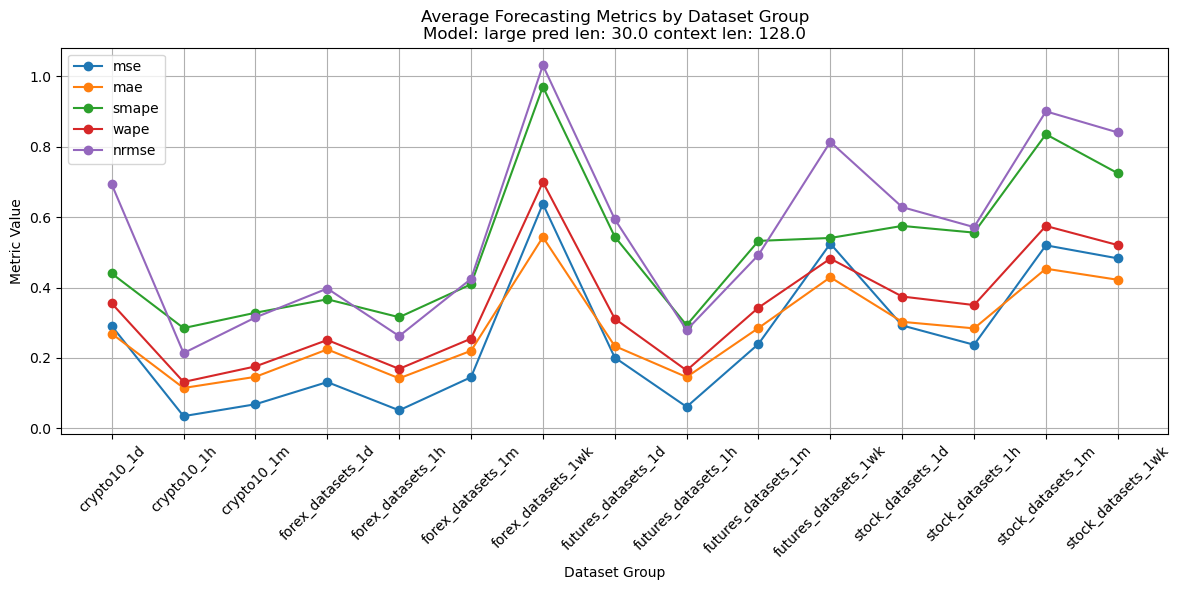


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=WAPE
✅ Filled 'TimesMOE Large' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.533066,0.622696,0.406333,0.548822,0.955574,3600.000000,2775.409180,3.891764,60.0,128.0,crypto10_1d
1,0.074708,0.384306,0.172504,0.198217,0.313512,20880.000000,18160.557617,22.188303,60.0,128.0,crypto10_1h
2,0.138654,0.422921,0.218041,0.262321,0.448431,8800.000000,7310.747721,9.274022,60.0,128.0,crypto10_1m
3,0.220529,0.482237,0.302363,0.337512,0.514324,6840.000000,6124.638184,7.384680,60.0,128.0,forex_datasets_1d
4,0.107025,0.422879,0.208626,0.247825,0.377415,20560.000000,17539.440104,22.879885,60.0,128.0,forex_datasets_1h
5,0.291079,0.565783,0.332999,0.385725,0.609282,12000.000000,10344.388346,12.889020,60.0,128.0,forex_datasets_1m
6,0.883304,1.199889,0.680231,0.876888,1.215506,1920.000000,1488.001546,2.132136,60.0,128.0,forex_datasets_1wk
7,0.381527,0.671700,0.330679,0.446451,0.834492,7080.000000,5251.835938,7.636587,60.0,128.0,futures_datasets_1d
8,0.112845,0.378006,0.206352,0.233168,0.379577,16080.000000,14230.702148,17.271233,60.0,128.0,futures_datasets_1h
9,0.322892,0.632296,0.357022,0.426120,0.619612,9000.000000,7713.614176,9.791542,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.4315
smape              0.6622
mae                0.3885
wape               0.4794
nrmse              0.7462
num_elements    8412.9351
abs_sum         7119.8149
total_time         9.1105
pred_len          60.0000
context_len      128.0000
dtype: float64


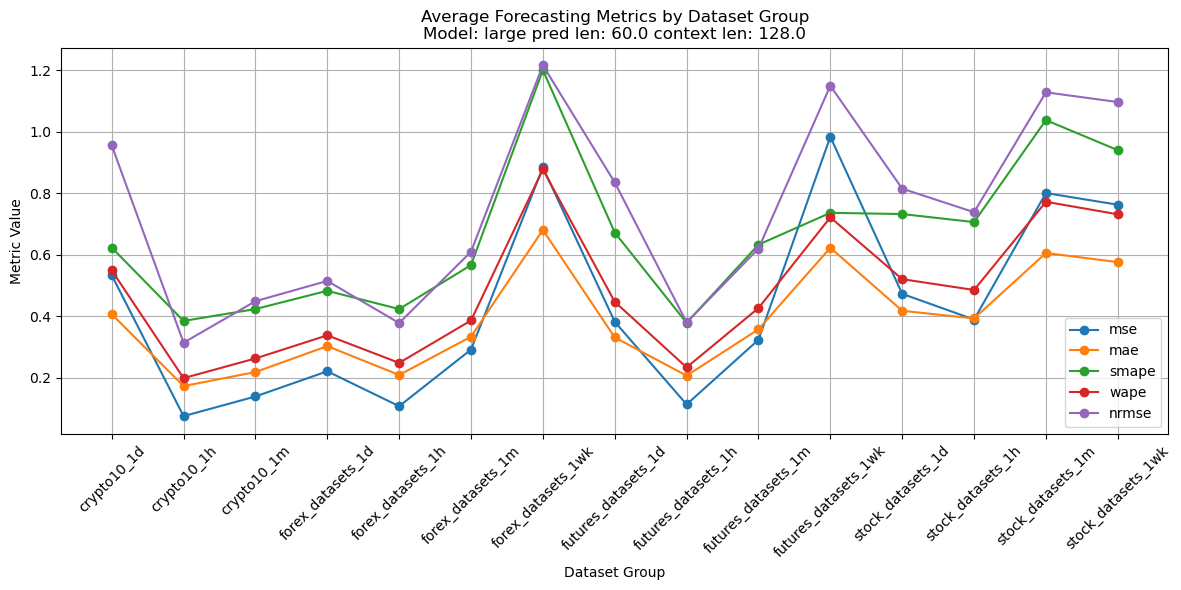


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=WAPE
✅ Filled 'TimesMOE Large' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: wape

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.192884,0.358176,0.208358,0.276314,0.567380,3653.333333,2840.513428,9.172409,20.0,128.0,crypto10_1d
1,0.023762,0.246365,0.095364,0.109595,0.177186,20880.000000,18160.557617,51.610696,20.0,128.0,crypto10_1h
2,0.046503,0.267205,0.119117,0.142735,0.258498,8853.333333,7392.073242,21.574010,20.0,128.0,crypto10_1m
3,0.090180,0.324805,0.183015,0.204842,0.327974,6920.000000,6179.074707,17.325769,20.0,128.0,forex_datasets_1d
4,0.035427,0.262559,0.115743,0.137029,0.217259,20693.333333,17704.054688,51.486228,20.0,128.0,forex_datasets_1h
5,0.094603,0.344021,0.174947,0.202140,0.337503,12160.000000,10519.006510,30.290631,20.0,128.0,forex_datasets_1m
6,0.509767,0.869793,0.476862,0.614063,0.922939,2000.000000,1563.865031,5.163369,20.0,128.0,forex_datasets_1wk
7,0.145981,0.479083,0.192486,0.255910,0.504311,7240.000000,5461.366089,18.181066,20.0,128.0,futures_datasets_1d
8,0.042576,0.241644,0.116028,0.131288,0.233477,16160.000000,14281.685547,40.533346,20.0,128.0,futures_datasets_1h
9,0.205751,0.468361,0.246864,0.297924,0.435336,9120.000000,7832.895752,22.902465,20.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.1884
smape              0.4449
mae                0.2316
wape               0.2839
nrmse              0.4750
num_elements    8500.5135
abs_sum         7219.2052
total_time        21.1994
pred_len          20.0000
context_len      128.0000
dtype: float64


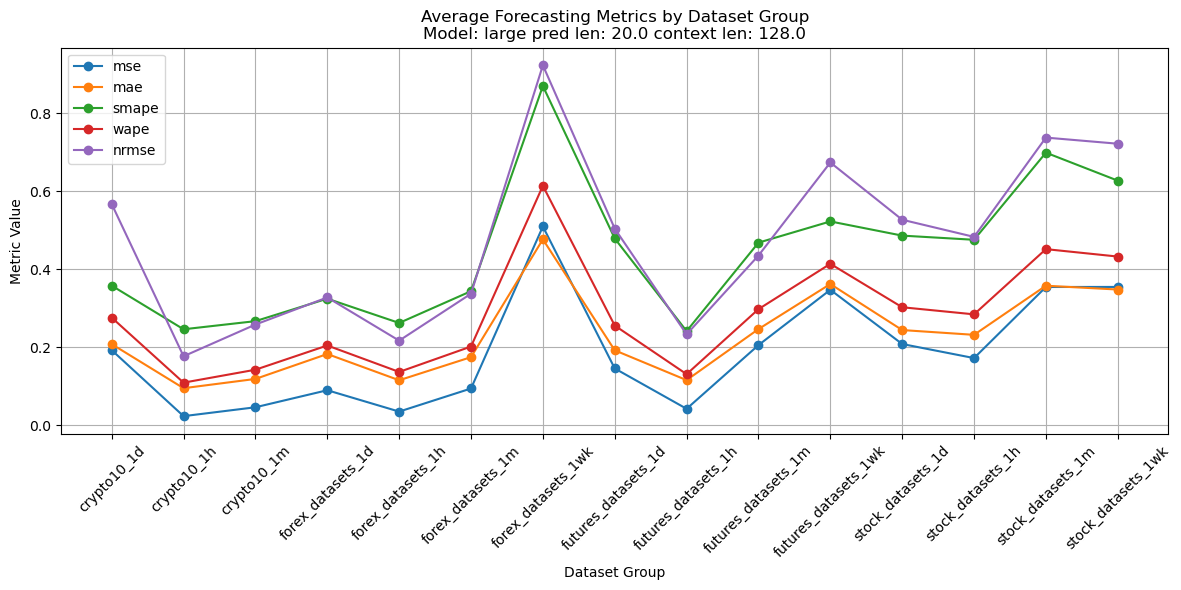


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=NRMSE
✅ Filled 'TimesMOE Large' (pred_len=20) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.290782,0.439859,0.268996,0.354951,0.693133,3680.000000,2867.131429,8.540728,30.0,128.0,crypto10_1d
1,0.034568,0.284720,0.114565,0.131668,0.213726,20880.000000,18160.559570,47.701517,30.0,128.0,crypto10_1h
2,0.068342,0.328316,0.146232,0.175831,0.314961,8800.000000,7310.747884,19.892892,30.0,128.0,crypto10_1m
3,0.131349,0.366561,0.224181,0.250870,0.397096,6900.000000,6164.434570,16.012319,30.0,128.0,forex_datasets_1d
4,0.051097,0.315649,0.141978,0.168896,0.262064,20640.000000,17603.581380,48.008559,30.0,128.0,forex_datasets_1h
5,0.145177,0.409186,0.220233,0.254665,0.424396,12120.000000,10474.398112,27.890211,30.0,128.0,forex_datasets_1m
6,0.637604,0.970492,0.543173,0.699432,1.031408,2040.000000,1600.562541,4.879077,30.0,128.0,forex_datasets_1wk
7,0.201020,0.544477,0.233643,0.311575,0.594247,7200.000000,5408.967285,16.650229,30.0,128.0,futures_datasets_1d
8,0.061010,0.292945,0.145608,0.164530,0.279101,16080.000000,14230.698242,37.747937,30.0,128.0,futures_datasets_1h
9,0.239605,0.532483,0.284984,0.342844,0.492552,9080.000000,7780.715047,21.335367,30.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.2612
smape              0.5144
mae                0.2810
wape               0.3438
nrmse              0.5638
num_elements    8482.6778
abs_sum         7197.0067
total_time        19.6422
pred_len          30.0000
context_len      128.0000
dtype: float64


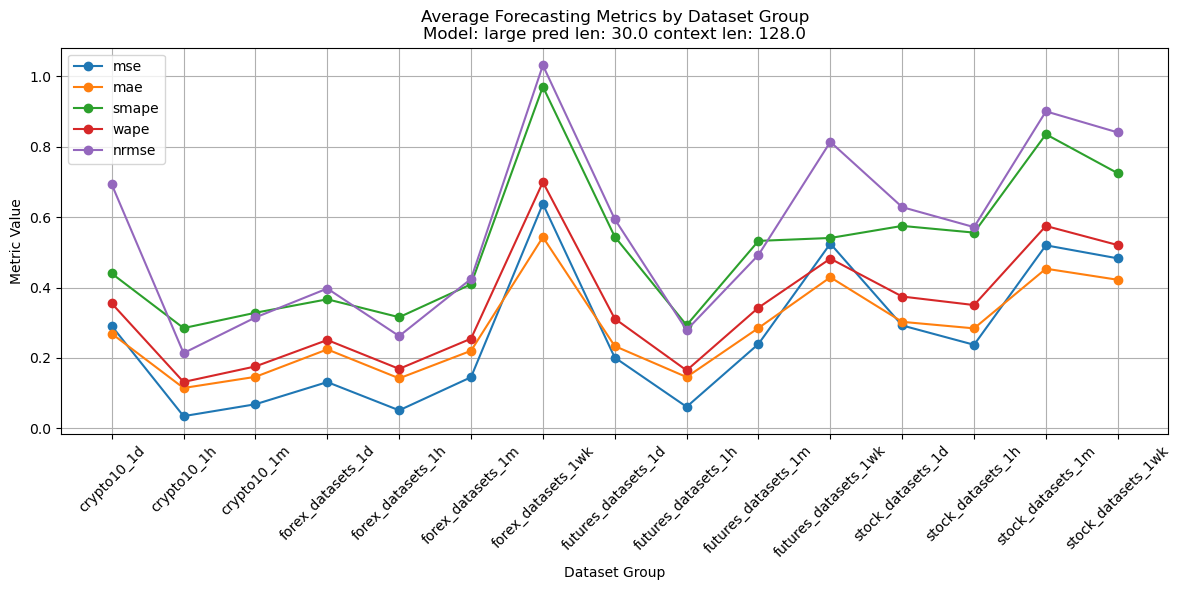


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=NRMSE
✅ Filled 'TimesMOE Large' (pred_len=30) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse

📊 Summary of Mean Metrics per Dataset Group:


,mse,smape,mae,wape,nrmse,num_elements,abs_sum,total_time,pred_len,context_len,group
0,0.533066,0.622696,0.406333,0.548822,0.955574,3600.000000,2775.409180,3.891764,60.0,128.0,crypto10_1d
1,0.074708,0.384306,0.172504,0.198217,0.313512,20880.000000,18160.557617,22.188303,60.0,128.0,crypto10_1h
2,0.138654,0.422921,0.218041,0.262321,0.448431,8800.000000,7310.747721,9.274022,60.0,128.0,crypto10_1m
3,0.220529,0.482237,0.302363,0.337512,0.514324,6840.000000,6124.638184,7.384680,60.0,128.0,forex_datasets_1d
4,0.107025,0.422879,0.208626,0.247825,0.377415,20560.000000,17539.440104,22.879885,60.0,128.0,forex_datasets_1h
5,0.291079,0.565783,0.332999,0.385725,0.609282,12000.000000,10344.388346,12.889020,60.0,128.0,forex_datasets_1m
6,0.883304,1.199889,0.680231,0.876888,1.215506,1920.000000,1488.001546,2.132136,60.0,128.0,forex_datasets_1wk
7,0.381527,0.671700,0.330679,0.446451,0.834492,7080.000000,5251.835938,7.636587,60.0,128.0,futures_datasets_1d
8,0.112845,0.378006,0.206352,0.233168,0.379577,16080.000000,14230.702148,17.271233,60.0,128.0,futures_datasets_1h
9,0.322892,0.632296,0.357022,0.426120,0.619612,9000.000000,7713.614176,9.791542,60.0,128.0,futures_datasets_1m



📌 Global Mean Across All Groups:
mse                0.4315
smape              0.6622
mae                0.3885
wape               0.4794
nrmse              0.7462
num_elements    8412.9351
abs_sum         7119.8149
total_time         9.1105
pred_len          60.0000
context_len      128.0000
dtype: float64


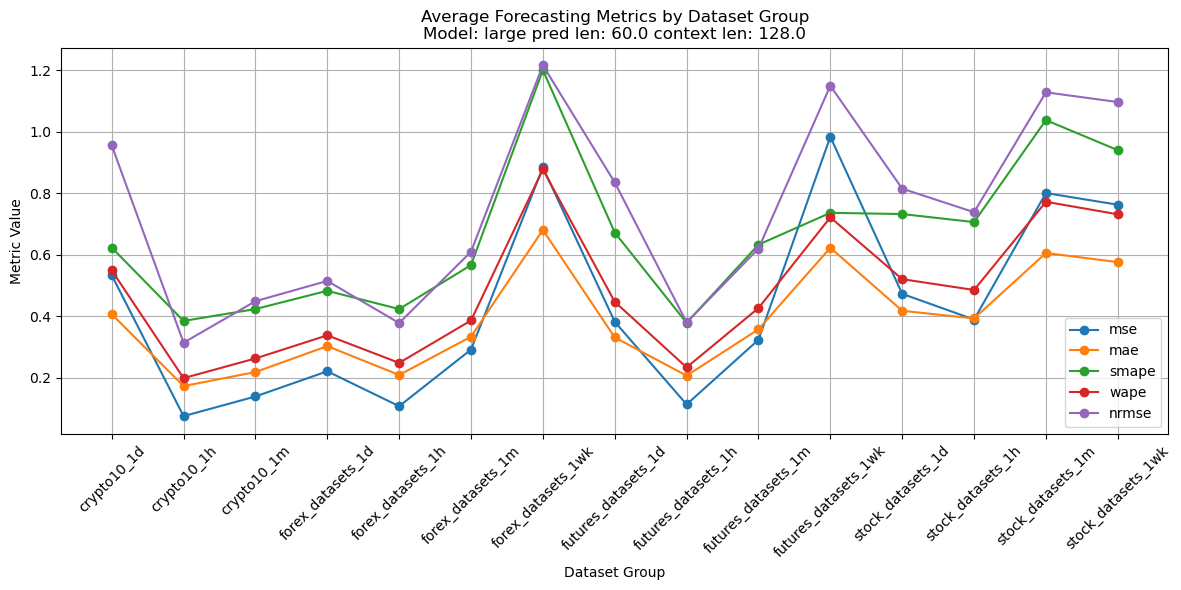


🔢 Total number of results.json files found: 908
🔎 Looking for model: 'TimesMOE Large'
  Col 8: model='TimesMOE Large' | metric=NRMSE
✅ Filled 'TimesMOE Large' (pred_len=60) into: C:\Users\11320\OneDrive\AI\ffm_sync\results_search.xlsx, sheet: nrmse


In [9]:
metrics = ["MSE", "MAE", "SMAPE", "WAPE", "NRMSE"]
result_excel_path = r"results\tsfm\tsMOE_large_of1"
L = [20, 30, 60]  
target_model = "TimesMOE Large"

for metric in metrics:
    for i in L:
        result_p = Path(r"{}\h{}".format(result_excel_path, str(i)))
        df = show_results(result_p)

        #data load into excel
        fill_model_metrics_into_excel(df, model_name=target_model, selected_metrics=[metric], excel_path=excel_file_path, output_path=excel_file_path, sheet_name=metric.lower())